# Convolutional Autoencoder for image denoising

- reference
    - https://keras.io/examples/vision/autoencoder/
    - https://blog.keras.io/building-autoencoders-in-keras.html

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder for image denoising, mapping noisy digits images from the MNIST dataset to clean digits images. This implementation is based on an original blog post titled Building Autoencoders in Keras by François Chollet.
- https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import random
import os

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(0)

## Setup

In [2]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

#     indices = np.random.randint(len(array1), size=n)
    indices = np.random.randint(10, size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Prepare the data

/home/jeongseobkim/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/jeongseobkim/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/jeongseobkim/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


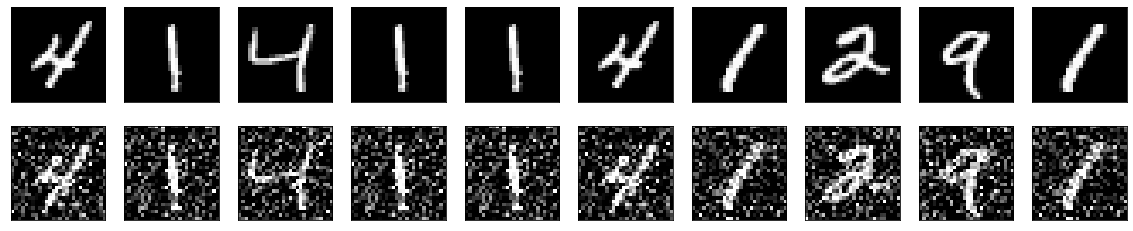

In [3]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
mnist = torchvision.datasets.mnist.MNIST(root='mnist_data', download=True)
train_data, test_data = mnist.train_data, mnist.test_data

# Normalize and reshape the data
train_data = preprocess(train_data.numpy())
test_data = preprocess(test_data.numpy())

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

noisy_train_data = np.array(noisy_train_data, dtype='float32')
noisy_test_data = np.array(noisy_test_data, dtype='float32')

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         289       
=================================================================
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________
```

In [4]:
class Conv_ae(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
 
    def forward(self,x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [5]:
from torchsummary import summary

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = Conv_ae()
model.to(device)

# summary(model, input_size=(1, 28, 28), device='cuda')

Conv_ae(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

**make dataset, dataloaer**

In [13]:
from torch.utils.data import DataLoader

if train_data.shape[1] != 1:
    train_data = train_data.swapaxes(1,-1)
    test_data = test_data.swapaxes(1,-1)

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

**set env**

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [15]:
n_epochs = 50
model.to(device)

for epoch in range(n_epochs):
    
    train_loss, val_loss = 0,0
    
    model.train()
    for train_data in train_dataloader:
        
        optimizer.zero_grad()
        
        x = train_data.to(device)
        y = train_data.to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
        
    model.eval()
    with torch.no_grad():
        for val_data in test_dataloader:
            
            x_val, y_val = val_data.to(device), val_data.to(device)
            
            pred_val = model(x_val)
            loss_val = criterion(pred_val, y_val)
            
            val_loss += float(loss_val)
            
    train_loss_ep = float(train_loss/len(train_dataloader))
    val_loss_ep = float(val_loss/len(test_dataloader))
    
    print(f"EPOCH {epoch} | LOSS : {train_loss_ep:.5f} ({val_loss_ep:.5f})")
        

/home/jeongseobkim/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH 0 | LOSS : 0.14420 (0.07632)
EPOCH 1 | LOSS : 0.07342 (0.07179)
EPOCH 2 | LOSS : 0.07078 (0.07000)
EPOCH 3 | LOSS : 0.06949 (0.06899)
EPOCH 4 | LOSS : 0.06862 (0.06822)
EPOCH 5 | LOSS : 0.06795 (0.06769)
EPOCH 6 | LOSS : 0.06743 (0.06715)
EPOCH 7 | LOSS : 0.06700 (0.06678)
EPOCH 8 | LOSS : 0.06665 (0.06647)
EPOCH 9 | LOSS : 0.06635 (0.06617)
EPOCH 10 | LOSS : 0.06609 (0.06591)
EPOCH 11 | LOSS : 0.06585 (0.06572)
EPOCH 12 | LOSS : 0.06566 (0.06557)
EPOCH 13 | LOSS : 0.06547 (0.06544)
EPOCH 14 | LOSS : 0.06532 (0.06534)
EPOCH 15 | LOSS : 0.06516 (0.06507)
EPOCH 16 | LOSS : 0.06502 (0.06497)
EPOCH 17 | LOSS : 0.06490 (0.06483)
EPOCH 18 | LOSS : 0.06477 (0.06468)
EPOCH 19 | LOSS : 0.06466 (0.06458)
EPOCH 20 | LOSS : 0.06457 (0.06455)
EPOCH 21 | LOSS : 0.06448 (0.06442)
EPOCH 22 | LOSS : 0.06438 (0.06431)
EPOCH 23 | LOSS : 0.06430 (0.06425)
EPOCH 24 | LOSS : 0.06423 (0.06418)
EPOCH 25 | LOSS : 0.06415 (0.06408)
EPOCH 26 | LOSS : 0.06409 (0.06409)
EPOCH 27 | LOSS : 0.06403 (0.06408)
EP

In [6]:
# save model(clean image reconstruction)

# torch.save(model, "model_clean_recon.pth")
del model
conv_ae = torch.load("model_clean_recon.pth")

In [17]:
pred_test = None

for test_data in test_dataloader:
    
    conv_ae.eval()
    with torch.no_grad():
        pred_test = conv_ae(test_data.to(device))

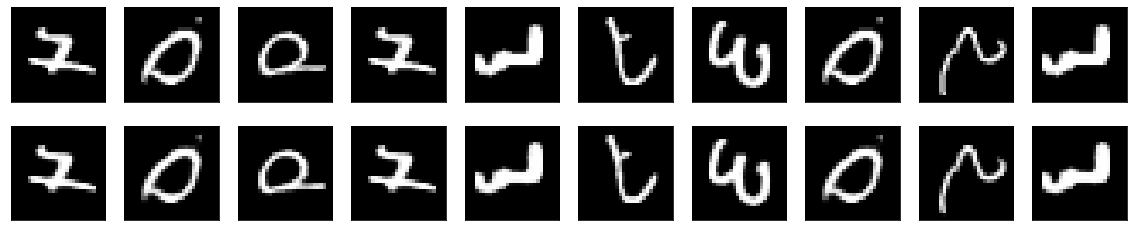

In [18]:
display(test_data, pred_test.detach().to("cpu"))

## Noisy to clean

In [7]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
mnist = torchvision.datasets.mnist.MNIST(root='mnist_data', download=True)
train_data, test_data = mnist.train_data, mnist.test_data

# Normalize and reshape the data
train_data = preprocess(train_data.numpy())
test_data = preprocess(test_data.numpy())

# Create a copy of the data with added noise
noisy_train_data = np.array(noise(train_data), dtype='float32')
noisy_test_data = np.array(noise(test_data), dtype='float32')

if noisy_train_data.shape[1] != 1:
    noisy_train_data = noisy_train_data.swapaxes(1,-1)
    noisy_test_data = noisy_test_data.swapaxes(1,-1)

if train_data.shape[1] != 1:
    train_data = train_data.swapaxes(1,-1)
    test_data = test_data.swapaxes(1,-1)

noisy_train_set = TensorDataset(torch.from_numpy(noisy_train_data), torch.from_numpy(train_data))
noisy_test_set = TensorDataset(torch.from_numpy(noisy_test_data), torch.from_numpy(test_data))

noisy_train_dataloader = DataLoader(noisy_train_set, batch_size=128, shuffle=False)
noisy_test_dataloader = DataLoader(noisy_test_set, batch_size=128, shuffle=False)

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(conv_ae.parameters())

In [10]:
n_epochs = 100
conv_ae.to(device)

for epoch in range(n_epochs):
    
    train_loss, val_loss = 0,0
    
    conv_ae.train()
    for x, y in noisy_train_dataloader:
        
        optimizer.zero_grad()
        
        x = x.to(device)
        y = y.to(device)
        
        pred = conv_ae(x)
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
        
        del x, y
        torch.cuda.empty_cache()
        
    conv_ae.eval()
    with torch.no_grad():
        for x_val, y_val in noisy_test_dataloader:
            
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            pred_val = conv_ae(x_val)
            loss_val = criterion(pred_val, y_val)
            
            val_loss += float(loss_val)
            
            del x_val, y_val
            torch.cuda.empty_cache()
            
    train_loss_ep = float(train_loss/len(noisy_train_dataloader))
    val_loss_ep = float(val_loss/len(noisy_test_dataloader))
    
    print(f"EPOCH {epoch} | LOSS : {train_loss_ep:.5f} ({val_loss_ep:.5f})")
        

EPOCH 0 | LOSS : 0.09433 (0.09361)
EPOCH 1 | LOSS : 0.09262 (0.09239)
EPOCH 2 | LOSS : 0.09161 (0.09150)
EPOCH 3 | LOSS : 0.09091 (0.09081)
EPOCH 4 | LOSS : 0.09037 (0.09027)
EPOCH 5 | LOSS : 0.08995 (0.08987)
EPOCH 6 | LOSS : 0.08959 (0.08953)
EPOCH 7 | LOSS : 0.08928 (0.08923)
EPOCH 8 | LOSS : 0.08901 (0.08897)
EPOCH 9 | LOSS : 0.08878 (0.08875)
EPOCH 10 | LOSS : 0.08858 (0.08856)
EPOCH 11 | LOSS : 0.08839 (0.08839)
EPOCH 12 | LOSS : 0.08823 (0.08823)
EPOCH 13 | LOSS : 0.08808 (0.08810)
EPOCH 14 | LOSS : 0.08793 (0.08798)
EPOCH 15 | LOSS : 0.08781 (0.08788)
EPOCH 16 | LOSS : 0.08769 (0.08780)
EPOCH 17 | LOSS : 0.08758 (0.08775)
EPOCH 18 | LOSS : 0.08748 (0.08766)
EPOCH 19 | LOSS : 0.08739 (0.08759)
EPOCH 20 | LOSS : 0.08730 (0.08753)
EPOCH 21 | LOSS : 0.08722 (0.08746)
EPOCH 22 | LOSS : 0.08715 (0.08739)
EPOCH 23 | LOSS : 0.08708 (0.08731)
EPOCH 24 | LOSS : 0.08701 (0.08724)
EPOCH 25 | LOSS : 0.08695 (0.08715)
EPOCH 26 | LOSS : 0.08689 (0.08708)
EPOCH 27 | LOSS : 0.08684 (0.08701)
EP

In [11]:
# save model(noisy to clean : denoising)

torch.save(conv_ae, "model_denoising.pth")
# conv_ae_denoise = torch.load("model_denoising.pth")

In [12]:
pred_test = None
x_test = None

for noisy, clean in noisy_test_dataloader:
    
    conv_ae.eval()
    with torch.no_grad():
        x_test = noisy
        pred_test = conv_ae(noisy.to(device))

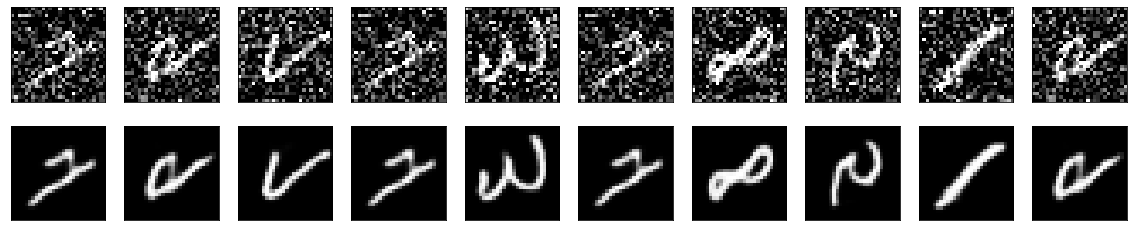

In [13]:
display(x_test.detach().to("cpu"), pred_test.detach().to("cpu"))